## Question: Where should you open a restaurant in Vancouver, British Columbia, Canada? 🍔

The City of Vancouver is a coastal, seaport city on the mainland of British Columbia. Located on the western half of the Burrard Peninsula, Vancouver is bounded to the north by English Bay and the Burrard Inlet and to the south by the Fraser River. Opening a restaurant or a business in Vancouver is a hot topic. Since it is a popular immigrant city, its growth and competition makes it a healthy place for business. However, restaurant culture in Vancouver is infamous for being unforgiving. Location, budget, culture, and timing are all important factors that play a huge part in a profitable ROI. That being said, the city has still amased a lot of interest from investors and business owners hoping to make it big. The important question is: **Where should someone set up a new restaurant in Vancouver? More importantly, what kind of restaurant should it be?**

Facts about Vancouver:
* Size: 114 square kilometres (44 square miles)
* Population: 631,486 (according to the 2016 census)
* Vancouver is the largest city in British Columbia
* Pacific time zone: GMT -8

In [235]:
# invite the architects
import pandas as pd
import numpy as np

# invite the artists
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import folium

# invite the scouts
from geopy.geocoders import Nominatim
import requests

# invite the helpers
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

# invite the ring leader
from sklearn.cluster import KMeans

# invite the judge
from sklearn.preprocessing import MinMaxScaler

In [233]:
# Where is Vancouver, anyways?
address = 'Vancouver, Canada'
geolocator = Nominatim(user_agent="exploring_vancouver")
location = geolocator.geocode(address)
vancity_latitude = location.latitude
vancity_longitude = location.longitude
map_vancouver = folium.Map(location=[vancity_latitude, vancity_longitude], zoom_start=3)
folium.Marker(location=[vancity_latitude, vancity_longitude]).add_to(map_vancouver)
print('The geograpical coordinate of {} are {}, {}.'.format(address,vancity_latitude, vancity_longitude))
map_vancouver

The geograpical coordinate of Vancouver, Canada are 49.2608724, -123.1139529.


I would like to preface that this is my first notebook exploring clustering algorithms. In my scratchwork, I played with both KMeans and DBSCAN. I defaulted to KMeans because of its speed and simplicity. DBScan does not work well over clusters with different densities, and this was apparent when I plotted all the venues in Vancouver. The concentrations of venues in Vancouver depend heavily on geographical area which was not evenly spaced and led to skewed densities. Below I give my general approach to this problem. 

### General Approach:

1. Find all the neighbourhoods in Central Vancouver from Open Data Vancouver
2. Find all the neighbourhoods' nearby venues
3. Cluster the nearby venues based on its many dimensions
4. Analyze patterns in each cluster
5. Drawing conclusions on where to best set up a restaurant in Vancouver!

### 1. Find all the neighbourhoods in Central Vancouver 

Luckily for us, Vancouver has an Open Data catalogue of some very interesting datasets about the city. I will grab the neighbourhood dataset for our purposes. Furthermore, I will append it with some older census data to give our algorithm some additional dimensions to draw clusters from.

In [37]:
# Nice, our neighbourhood data looks pretty clean and minimal. There are 22 neighbourhoods to deal with.
neighbourhood_data = pd.read_csv('ftp://webftp.vancouver.ca/OpenData/csv/cov_localareas.csv')
# Lets rename NAME to Neighbourhood and get rid of MAPID
neighbourhood_data = neighbourhood_data.rename({'NAME':'Neighbourhood'}, axis='columns').drop('MAPID',axis=1)
# Lets also give our dataframe a Latitude and Longitude column for our neighbourhoods
neighbourhood_data['Latitude'] = ''
neighbourhood_data['Longitude'] = ''
# Now let's find the Latitude and Longitude of each neighbourhood for plotting later
for i, row in neighbourhood_data.iterrows():
    address_iter = '{}, Vancouver, Canada'.format(row['Neighbourhood'])
    location = geolocator.geocode(address_iter)
    neighbourhood_data.at[i,'Latitude'] = location.latitude
    neighbourhood_data.at[i,'Longitude'] = location.longitude
# Let's see the fruits of our labour!
neighbourhood_data.head()

Neighbourhood Latitude Longitude
0          Sunset  49.2196   -123.09
1  Mount Pleasant  49.2633  -123.097
2      Riley Park  49.2474  -123.103
3        Downtown  49.2834  -123.117
4       Kitsilano  49.2694  -123.155

In [293]:
# Yikes, our census data actually looks pretty dirty. Let's clean it up and merge it with our neighbourhood data.
census_data = pd.read_csv('ftp://webftp.vancouver.ca/opendata/csv/CensusLocalAreaProfiles2016.csv',encoding='ISO-8859-1')
# Remove the first three rows because they are not needed
census_data = census_data.iloc[3:]
# Set the columns as the values in the first row
census_data.columns = census_data.iloc[0]
# Remove the first row after setting the row to the columns
census_data = census_data.iloc[1:]
# Remove all NaN rows (blank rows)
census_data.dropna(inplace=True)
# Grab all the data that contains the keyword "Average"
census_data = census_data[census_data['Variable'].str.contains("Average")]
# Drop the ID Column since we already have an index
census_data.drop('ID',axis=1,inplace=True)
# Set the index as Variable to transpose
census_data.set_index('Variable',inplace=True)
# Transpose the data so the rows reflect the relevant neighbourhoods
census_data = census_data.T
# Strip the leading/trailing spaces in the neighbourhood index
census_data['Neighbourhood'] = census_data.index.str.strip()
# Show the data
census_data.head(10)

Variable                  Average age of the population  \
3                                                         
Arbutus-Ridge                                      44.6   
Downtown                                           40.6   
Dunbar-Southlands                                  41.1   
Fairview                                           43.4   
Grandview-Woodland                                 40.2   
Hastings-Sunrise                                   42.3   
Kensington-Cedar Cottage                             40   
Kerrisdale                                         42.9   
Killarney                                          42.4   
Kitsilano                                          40.6   

Variable                    Average age of males   Average age of females  \
3                                                                           
Arbutus-Ridge                               42.2                     46.5   
Downtown                                    41.1                     40.1   
Dunbar-Southlands                           40.1                       42   
Fairview                                    42.1                     44.5   
Grandview-Woodland                          39.8                     40.5   
Hastings-Sunrise                            41.4                     43.2   
Kensington-Cedar Cottage                    39.1                     40.8   
Kerrisdale                                  41.7                       44   
Killarney                                   40.8                     43.8   
Kitsilano                                   39.9                     41.2   

Variable                  Average size of census families  \
3                                                           
Arbutus-Ridge                                         2.9   
Downtown                                              2.4   
Dunbar-Southlands                                       3   
Fairview                                              2.4   
Grandview-Woodland                                    2.6   
Hastings-Sunrise                                      2.9   
Kensington-Cedar Cottage                              2.9   
Kerrisdale                                            2.9   
Killarney                                             2.9   
Kitsilano                                             2.5   

Variable                  Average household size  \
3                                                  
Arbutus-Ridge                                2.4   
Downtown                                     1.7   
Dunbar-Southlands                            2.8   
Fairview                                     1.7   
Grandview-Woodland                           1.9   
Hastings-Sunrise                             2.7   
Kensington-Cedar Cottage                     2.7   
Kerrisdale                                   2.5   
Killarney                                    2.7   
Kitsilano                                    1.9   

Variable                      Average total income in 2015 among recipients ($)  \
3                                                                                 
Arbutus-Ridge                                                          62675      
Downtown                                                               63251      
Dunbar-Southlands                                                      78117      
Fairview                                                               61627      
Grandview-Woodland                                                     42896      
Hastings-Sunrise                                                       38258      
Kensington-Cedar Cottage                                               38411      
Kerrisdale                                                             77248      
Killarney                                                              39013      
Kitsilano                                                              63092      

Variable   

In [294]:
# Merge the neighbourhood data and census data
data = pd.merge(neighbourhood_data, census_data, on='Neighbourhood')
data.head()

Neighbourhood Latitude Longitude Average age of the population  \
0          Sunset  49.2196   -123.09                          39.8   
1  Mount Pleasant  49.2633  -123.097                          38.3   
2      Riley Park  49.2474  -123.103                          40.2   
3        Downtown  49.2834  -123.117                          40.6   
4       Kitsilano  49.2694  -123.155                          40.6   

    Average age of males   Average age of females  \
0                   38.6                       41   
1                   38.1                     38.5   
2                   39.2                     41.1   
3                   41.1                     40.1   
4                   39.9                     41.2   

  Average size of census families Average household size  \
0                             3.1                    3.1   
1                             2.5                    1.8   
2                             2.9                    2.5   
3                             2.4                    1.7   
4                             2.5                    1.9   

      Average total income in 2015 among recipients ($)  \
0                                              34212      
1                                              54260      
2                                              53060      
3                                              63251      
4                                              63092      

      Average after-tax income in 2015 among recipients ($)  ...  \
0                                              29593         ...   
1                                              44303         ...   
2                                              43171         ...   
3                                              49390         ...   
4                                              49729         ...   

    Average family size of couple economic families without children or other relatives  \
0                                                  2                                      
1                                                  2                                      
2                                                  2                                      
3                                                  2                                      
4                                                  2                                      

    Average total income of couple economic families with children in 2015 ($)  \
0                                             115299                             
1                                             147571                             
2                                             169491                             
3                                             141100                             
4                                             187381                             

    Average after-tax income of couple economic families with children in 2015 ($)  \
0                                              99200                                 
1                                             117847                                 
2                                             136043                                 
3                                             111547                                 
4                                             142522                                 

    Average family size of couple economic families with children  \
0                                                4.4                
1                                                3.6                
2                                                3.9                
3                                                3.5                
4                                                3.6                

    Average total income of lone-parent economic families in 2015 ($)  \
0                                              65473                    
1                    

In [295]:
# Awesome, now that we have our relevant data, let's plot the neighbourhoods on a map to see what we are working with!
map_neighbourhoods = folium.Map(location=[vancity_latitude, vancity_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(data['Latitude'], data['Longitude'], data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_neighbourhoods)  
    
map_neighbourhoods

### 2. Find all the neighbourhoods' nearby venues in Central Vancouver

Now that we have all the neighbourhoods in Central Vancouver, we can use the FourSquare API to find the venues that surround each neighbourhood. This will give us a good picture of what kinds of restrauants, shops, and interesting places there are in neighbourhoods. After this, we will cluster the venues based on their similarities. This grouping can help us find insights on where to best open a restaurant in Vancouver. Let's get to it.

In [297]:
# Shh, credentials.... please don't share!
CLIENT_ID = 'QGIGC40OIPFLAHA4SZRPLBFFNM1QXA4V2G2LQW5244VYY50P'
CLIENT_SECRET = 'QSE3UMXWQFRONXR4SACUKZJ1HY3HMVYZM1IOT3B1EZXWN0YQ' 
VERSION = '20180605'

In [54]:
# Let's grab the nearby venues of each neighbourhood. I found this function online and I am using it for efficiency. All credit goes to the original author.
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# get nearby venues
vancouver_venues = getNearbyVenues(names=clean_df["Neighbourhood"], 
                                 latitudes=clean_df["Latitude"], 
                                 longitudes=clean_df["Longitude"])
vancouver_venues.head()

Neighbourhood  Neighborhood Latitude  Neighborhood Longitude  \
0        Sunset              49.219593             -123.090239   
1        Sunset              49.219593             -123.090239   
2        Sunset              49.219593             -123.090239   
3        Sunset              49.219593             -123.090239   
4        Sunset              49.219593             -123.090239   

                     Venue  Venue Latitude  Venue Longitude  \
0      Breka Bakery & Café       49.225172      -123.090856   
1  So Hyang Korean Cuisine       49.227019      -123.090842   
2               Shoom 雅菀食府       49.224861      -123.090948   
3      Panos Greek Taverna       49.210968      -123.092143   
4   Deer Garden Signatures       49.227635      -123.090703   

         Venue Category  
0                Bakery  
1     Korean Restaurant  
2  Cantonese Restaurant  
3            Restaurant  
4    Chinese Restaurant

In [60]:
# Just curious, how many venues do we have?
vancouver_venues.shape

(1463, 7)

In [57]:
# Now that we have all the corresponding venues of each neighbourhood in a single dataframe, let's plot our results. This will be the plots that we cluster and build insights upon.
map_venues = folium.Map(location=[vancity_latitude, vancity_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(vancouver_venues['Venue Latitude'], vancouver_venues['Venue Longitude'], vancouver_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#00A86B',
        fill_opacity=0.7).add_to(map_venues)  
    
map_venues

Wow, that's a lot of venues (1463 to be exact, haha). It sounds like its time to do some clustering!

### 3. Cluster the nearby venues based on its many dimensions

In our data, each venue has different fields based on its given location and neighbourhood. I predict that this will lead to clusters formed around neighbourhoods, but also some disparate clusters matched together based on things like income and household size. I will plot a centroid in clusters that are not split apart because it will be easier to visualize those as "hot spots". For clusters that are split, I will simply do a numeric and qualititve analysis on those instead. Let's go!

In [71]:
# Let's add back the metadata because our helper function removed it
cluster_data = pd.merge(vancouver_venues, data, on='Neighbourhood')
# Prepping our data for clustering by dropping categorical values and neighbourhood context
cluster_data = cluster_data.drop(['Neighbourhood','Neighborhood Latitude','Neighborhood Longitude','Venue Category','Venue'],axis=1)
# Ensuring that all the values are numeric  
cluster_data = cluster_data.astype(float)
# One-hot encode this bad boy
cluster_data = pd.get_dummies(cluster_data)
cluster_data.head()

Venue Latitude  Venue Longitude   Latitude   Longitude  \
0       49.225172      -123.090856  49.219593 -123.090239   
1       49.227019      -123.090842  49.219593 -123.090239   
2       49.224861      -123.090948  49.219593 -123.090239   
3       49.210968      -123.092143  49.219593 -123.090239   
4       49.227635      -123.090703  49.219593 -123.090239   

   Average age of the population    Average age of males  \
0                           39.8                    38.6   
1                           39.8                    38.6   
2                           39.8                    38.6   
3                           39.8                    38.6   
4                           39.8                    38.6   

     Average age of females  Average size of census families  \
0                      41.0                              3.1   
1                      41.0                              3.1   
2                      41.0                              3.1   
3                      41.0                              3.1   
4                      41.0                              3.1   

   Average household size  \
0                     3.1   
1                     3.1   
2                     3.1   
3                     3.1   
4                     3.1   

       Average total income in 2015 among recipients ($)  ...  \
0                                            34212.0      ...   
1                                            34212.0      ...   
2                                            34212.0      ...   
3                                            34212.0      ...   
4                                            34212.0      ...   

     Average family size of couple economic families without children or other relatives  \
0                                                2.0                                       
1                                                2.0                                       
2                                                2.0                                       
3                                                2.0                                       
4                                                2.0                                       

     Average total income of couple economic families with children in 2015 ($)  \
0                                           115299.0                              
1                                           115299.0                              
2                                           115299.0                              
3                                           115299.0                              
4                                           115299.0                              

     Average after-tax income of couple economic families with children in 2015 ($)  \
0                                            99200.0                                  
1                                            99200.0                                  
2                                            99200.0                                  
3                                            99200.0                                  
4                                            99200.0                                  

     Average family size of couple economic families with children  \
0                                                4.4                 
1                                                4.4                 
2                                                4.4                 
3                                                4.4                 
4                                                4.4                 

     Average total income of lone-parent economic families in 2015 ($)  \
0                                            65473.0                     
1                                            65473.0                     
2                                            65473.0                     
3                               

In [304]:
# Now that we have our clustered data, let's find the optimal K by plotting the variances
# First, let's do a bit of preprocessing to ensure no bias weights in our data
mms = MinMaxScaler()
data_transformed = mms.fit_transform(cluster_data)

In [306]:
# Next, lets initialize an array to hold our plot points.
Sum_of_squared_distances = []
K = range(1,15)
# fit our data for different values of K
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

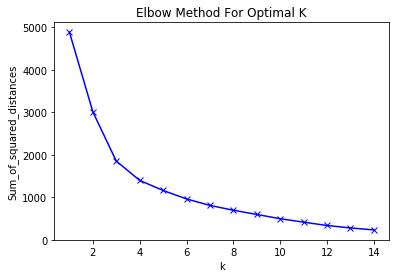

In [307]:
# Render a elbow plot and choose the elbow (i.e where the variance begins to slow down)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal K')
plt.show()

It seems like from the elbow graph that our optimal K is 5. Let's cluster our data with that!

In [298]:
# It's time to cluster our data!
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_data)

In [263]:
# Get a copy of original venue data and add a cluster column to it
clustered_data = vancouver_venues
clustered_data['Cluster'] = kmeans.labels_
# How many clusters do we have? Should be equal to kclusters variable...
num_clusters = len(set(clustered_data['Cluster']))
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 5


In [264]:
# Let's get the centermost point for each cluster to plot its "hot spot". This will only apply to clusters that are not split!
# Grabbing the venue coordinates in clustered data
coords = clustered_data[['Venue Latitude', 'Venue Longitude']].values
# Getting all the cluster labels in an array
cluster_labels = kmeans.labels_
# Initializing a Series of venue coordinates and setting the index to its corresponding cluster
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

# This get_centermost_point function was found online. All credits go to its author.
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

# This will grab the centermost point of each respective cluster. The index of the array is the cluster.
centermost_points = clusters.map(get_centermost_point)
centermost_points

0    (49.27481795469032, -123.10013301157448)
1                    (49.257808, -123.175355)
2                    (49.238462, -123.116045)
3    (49.24986502637116, -123.08996909239023)
4      (49.2343145994551, -123.1399634664646)
dtype: object

In [265]:
# Before we plot, let's arrange a rainbow colour scheme for the clusters. This was found online. All credits go to its author.
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [266]:
# Let's plot the clusters on the map and see what we got!
map_clustered = folium.Map(location=[vancity_latitude, vancity_longitude], zoom_start=10)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clustered_data['Venue Latitude'], clustered_data['Venue Longitude'], clustered_data['Neighbourhood'], clustered_data['Cluster']):
    text = 'Cluster ' + str(cluster)
    label = folium.Popup(text, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clustered)
    
map_clustered

In [246]:
# Wow, that is insanely colourful. Let's add centroid points to all the clusters that are not split!
for ind in range(kclusters):
    folium.Circle(
        location=[centermost_points.iloc[ind][0], centermost_points.iloc[ind][1]],
        radius=500,
        #popup='Cluster ' + str(ind),
        color='red',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map_clustered)
map_clustered

There is a lot of interesting visuals here! The red centroid circles indicate the middle of a respective cluster - it should show some indication of similar venue types for that specific cluster. Broadly, we can see that clusters are split mainly by geographic location (which makes sense). The clusters that are split will reveal some interesting options for the restaurant owner. It may show similarities in income and interest in different regions. In the next section, I will analyze the similarities in each cluster and give recommendations on where to open different types of restaurants.

### 4. Analyze patterns in each cluster

In this section, I will utilize matplotlib in order to draw some interesting insights on our clustered data. This includes the most popular venue types, the different types of venues, which neighbourhood they belong to, and more. For each cluster, I will go through the same aforementioned topics. This should reveal where one should open a restaurant in vancouver (based on neighbourhood or area at least).

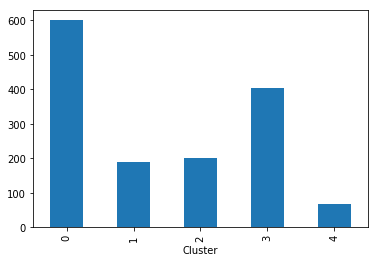

In [267]:
# Which cluster is the most dense (which cluster has the most venues)?
clustered_data.groupby('Cluster')['Venue'].count().plot(kind='bar')

Cool, it seems like cluster 0 (the Greater Vancouver Area) holds the most venues. Let's build a helper function help us better understand each cluster!

In [268]:
# Aside: We will write a helper function to plot the corresponding neighbourhoods, venues, and restarurant filtered venues of each cluster
def plot_cluster_graphs(cluster):
    plot_cluster = clustered_data[clustered_data['Cluster'] == cluster]
    plt.subplot(3, 1, 1)
    plot_cluster["Neighbourhood"].value_counts().plot(kind='bar', title="Cluster " + str(cluster) + "'s Neighbourhood spread")
    plt.subplot(3, 1, 2)
    plot_cluster['Venue Category'].value_counts().head(10).plot(kind='bar', title="Cluster " + str(cluster) + "'s Venue spread")
    plt.subplot(3, 1, 3)
    plot_cluster[plot_cluster['Venue Category'].str.contains("Restaurant")]['Venue Category'].value_counts().head().plot(kind='bar', title="Cluster " + str(cluster) + "'s Restaurant Venue spread")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=3, wspace=None, hspace=1)
    plt.show()

# another helper function to render out the map of a specific cluster
def plot_cluster_map(cluster):
    cluster_x = clustered_data[clustered_data.Cluster == cluster]
    map_clustered_x = folium.Map(location=[centermost_points.iloc[cluster][0], centermost_points.iloc[cluster][1]], zoom_start=12)

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(cluster_x['Venue Latitude'], cluster_x['Venue Longitude'], cluster_x['Neighbourhood'], cluster_x['Cluster']):
        text = 'Cluster ' + str(cluster)
        label = folium.Popup(text, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(map_clustered_x)
        
    return map_clustered_x

### Cluster 0: Downtown Vancouver

In [273]:
# Let's analyze the first cluster (Cluster 0)
cluster_0 = clustered_data[clustered_data.Cluster == 0]
cluster_0.head()

Neighbourhood  Neighborhood Latitude  Neighborhood Longitude  \
49  Mount Pleasant               49.26333             -123.096588   
50  Mount Pleasant               49.26333             -123.096588   
51  Mount Pleasant               49.26333             -123.096588   
52  Mount Pleasant               49.26333             -123.096588   
53  Mount Pleasant               49.26333             -123.096588   

                 Venue  Venue Latitude  Venue Longitude     Venue Category  \
49  Dude Chilling Park       49.263730      -123.096796  Outdoor Sculpture   
50  La petite cuillère       49.263533      -123.099900           Tea Room   
51           Sushiyama       49.262897      -123.097169   Sushi Restaurant   
52   Pulpfiction Books       49.263553      -123.100734          Bookstore   
53   Budgie’s Burritos       49.263714      -123.100292      Burrito Place   

    Cluster  
49        0  
50        0  
51        0  
52        0  
53        0

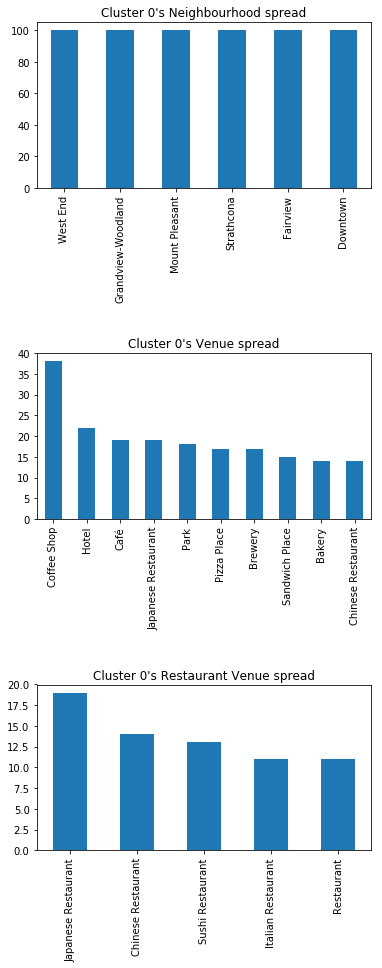

In [269]:
# Plotting cluster 0 graphs and map
plot_cluster_graphs(0)
plot_cluster_map(0)

Cluster 0 is effectively Downtown Vancouver and its close surrounding areas. It's commonplace for Vancouver locals to know that the best Japanese Restaurants are downtown - and the data reflects that! Many coffee shops and hotels riddle the area as well for tourists and business professionals alike. If a restaurant owner is hoping to open up a Japanese Restaurant (ramen?), it seems like Downtown Vancouver is the place to be!

### Cluster 1: West Point Grey and Kerrisdale

In [278]:
# Let's analyze the Cluster 1
cluster_1 = clustered_data[clustered_data.Cluster == 1]
cluster_1.head()

Neighbourhood  Neighborhood Latitude  Neighborhood Longitude  \
449  Dunbar-Southlands               49.25346             -123.185044   
450  Dunbar-Southlands               49.25346             -123.185044   
451  Dunbar-Southlands               49.25346             -123.185044   
452  Dunbar-Southlands               49.25346             -123.185044   
453  Dunbar-Southlands               49.25346             -123.185044   

                                     Venue  Venue Latitude  Venue Longitude  \
449                         Dunbar Theater       49.245613      -123.185428   
450                 Handi Cuisine of India       49.246758      -123.185250   
451                               La Notte       49.257353      -123.185245   
452                        TD Canada Trust       49.248877      -123.185031   
453  Beauty Boutique by Shoppers Drug Mart       49.247675      -123.185062   

          Venue Category  Cluster  
449  Indie Movie Theater        1  
450    Indian Restaurant        1  
451   Italian Restaurant        1  
452                 Bank        1  
453       Cosmetics Shop        1

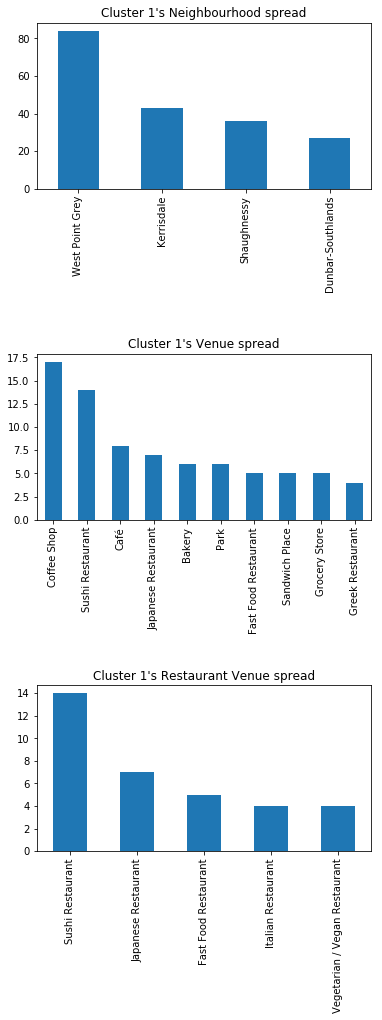

In [279]:
plot_cluster_graphs(1)
plot_cluster_map(1)

Cluster 1 is equally interesting. The cluster is anchored to West Point Grey which does have a relatively high average income (in general, the further west you move along Vancouver, the richer the households). Sushi Restaurants seem to dominate this area. This area is the close to the University of British Columbia and a quick Sushi fix is popular among students. Fast Food also claims its place in the top 3 restaurant venues. Let it be known that Fast food Sushi Restaurants should open in the West Point Grey area!

### Cluster 2: Riley Park and Marpole

In [286]:
# Let's analyze the Cluster 2
cluster_2 = clustered_data[clustered_data.Cluster == 2]
cluster_2.head()

Neighbourhood  Neighborhood Latitude  Neighborhood Longitude  \
149    Riley Park              49.247438             -123.102966   
150    Riley Park              49.247438             -123.102966   
151    Riley Park              49.247438             -123.102966   
152    Riley Park              49.247438             -123.102966   
153    Riley Park              49.247438             -123.102966   

                        Venue  Venue Latitude  Venue Longitude  \
149              Meet on Main       49.246747      -123.101096   
150  Sawasdee Thai Restaurant       49.247072      -123.101080   
151           Red Cat Records       49.246413      -123.101115   
152              East is East       49.245431      -123.101273   
153                 The Acorn       49.249442      -123.101105   

                    Venue Category  Cluster  
149  Vegetarian / Vegan Restaurant        2  
150                Thai Restaurant        2  
151                    Record Shop        2  
152      Middle Eastern Restaurant        2  
153  Vegetarian / Vegan Restaurant        2

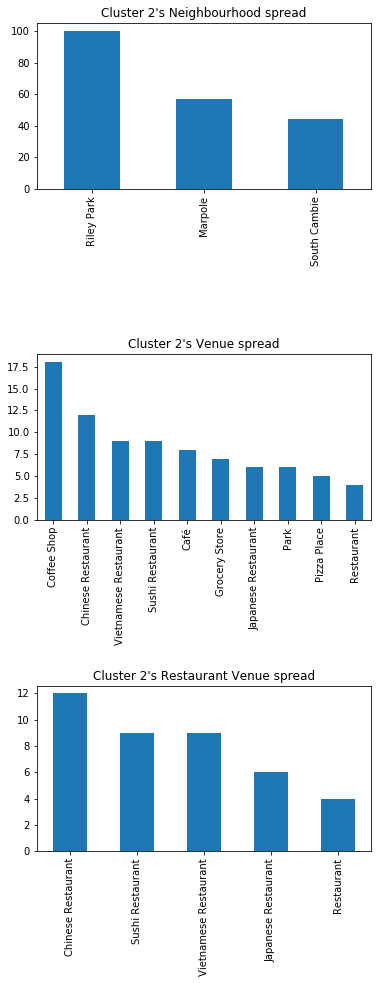

In [287]:
plot_cluster_graphs(2)
plot_cluster_map(2)

Cluster 2 is riddled with Asian eats. However, filtering strictly for restaurant reveals that Chinese restarants are popular in these two locations, Marpole and Riley Park. These areas do have a healthy Chinese population so it makes sense. If a restaurant owner wants to open a Chinese restaurant, anywhere in Marpole or Riley Park seems like a pretty good choice!

### Cluster 3: Kitsilano and surrounding areas

In [288]:
# Let's analyze the Cluster 3
cluster_3 = clustered_data[clustered_data.Cluster == 3]
cluster_3.head()

Neighbourhood  Neighborhood Latitude  Neighborhood Longitude  \
0        Sunset              49.219593             -123.090239   
1        Sunset              49.219593             -123.090239   
2        Sunset              49.219593             -123.090239   
3        Sunset              49.219593             -123.090239   
4        Sunset              49.219593             -123.090239   

                     Venue  Venue Latitude  Venue Longitude  \
0      Breka Bakery & Café       49.225172      -123.090856   
1  So Hyang Korean Cuisine       49.227019      -123.090842   
2               Shoom 雅菀食府       49.224861      -123.090948   
3      Panos Greek Taverna       49.210968      -123.092143   
4   Deer Garden Signatures       49.227635      -123.090703   

         Venue Category  Cluster  
0                Bakery        3  
1     Korean Restaurant        3  
2  Cantonese Restaurant        3  
3            Restaurant        3  
4    Chinese Restaurant        3

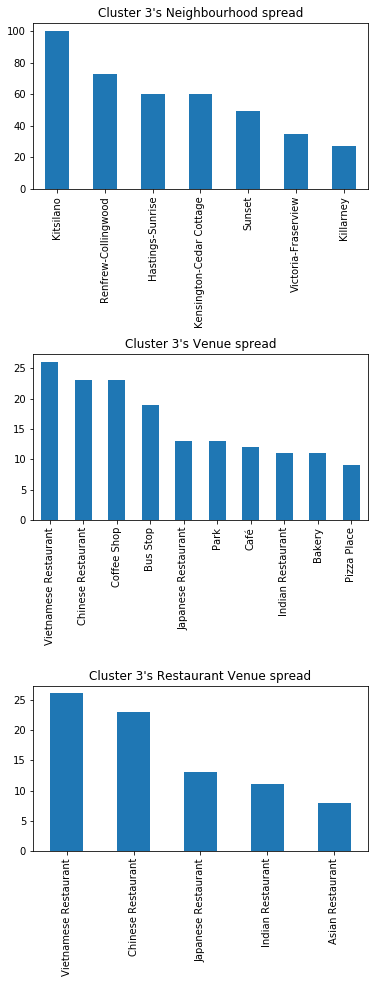

In [259]:
plot_cluster_graphs(3)
plot_cluster_map(3)

Cluster 3 is pretty much the Greater Vancouver Area. It is split between the hipster part of Kitsilano, to earthly Hastings, and the rest. I was surprised to find that Vietnamese restaurants are most popular *around* the Vancouver Area. The draw this conclusion based on Vietnamese immigrants moving here and settling in the middle class working within the restaurant culture. If a restaurant owner wants to open a Vietnamese Restaurant, anywhere in Kitsilano or the surrounding Vancouver Area would be a good choice.

### Cluster 4: Oakridge and Arbutus-Ridge

In [289]:
# Let's analyze the Cluster 4
cluster_4 = clustered_data[clustered_data.Cluster == 4]
cluster_4.head()

Neighbourhood  Neighborhood Latitude  Neighborhood Longitude  \
519  Arbutus-Ridge              49.240968             -123.167001   
520  Arbutus-Ridge              49.240968             -123.167001   
521  Arbutus-Ridge              49.240968             -123.167001   
522  Arbutus-Ridge              49.240968             -123.167001   
523  Arbutus-Ridge              49.240968             -123.167001   

                            Venue  Venue Latitude  Venue Longitude  \
519            Butter Baked Goods       49.242209      -123.170381   
520  Minerva's Pizza & Steakhouse       49.234674      -123.161774   
521                        Bufala       49.237434      -123.155576   
522                     Starbucks       49.234635      -123.160552   
523                 Bean Brothers       49.234713      -123.157260   

         Venue Category  Cluster  
519              Bakery        4  
520  Italian Restaurant        4  
521         Pizza Place        4  
522         Coffee Shop        4  
523      Sandwich Place        4

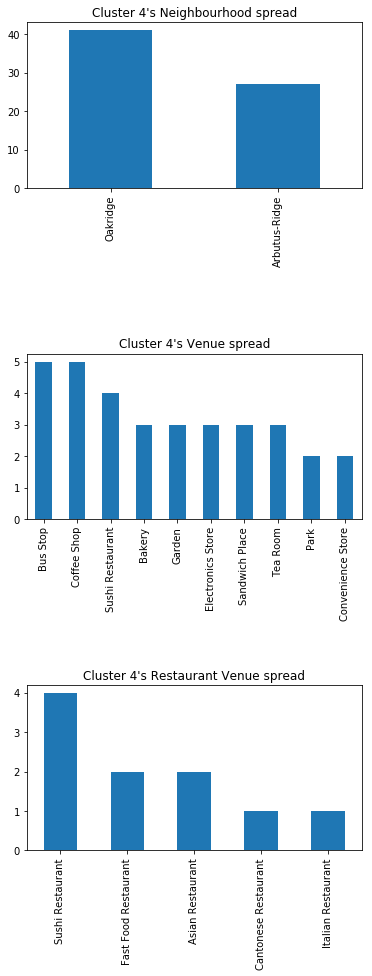

In [290]:
plot_cluster_graphs(4)
plot_cluster_map(4)

Since I am a Vancouver local, I know a lot of transit runs through this area. Oakridge is considered a middle class area, but houses many students that humbly transit westward to UBC. This explains the majority of Bus Stop venues and Sushi Restaurants. Why Sushi Restaurants? Well, students and workers alike are always eager for a quick bite, and sushi is a reliable cheap option. Anywhere that screams middle class, students, and affordable in Vancouver is a haven for Sushi Restaurants. So if you are restaurant owner, don't be afraid to open up a Sushi Restaurant around Arbutus or Oakridge!

### 5. Drawing conclusions on where to best set up a restaurant in Vancouver!

The clustering above reveal patterns that rely on the location, income, houseland size, and number/type/gender of people in each neighbourhood. It reveals that each cluster has its own restaurant specialization that best fits its demographic.  

Based on the results above, the type and location of a new restaurant in Vancouver should follow these rules:
* Cluster 0: If someone is interested in setting up a restaurant in **Downtown Vancouver**, they should consider a **Japanese Restaurant**. This is because Downtown Vancouver holds the densest Japanese population in Vancouver and is a hot tourist destination spot. It is known that tourists will pay a lot for Japanese Food in central Downtown Vancouver - check out [Miku](https://mikurestaurant.com)
! 🍜
* Cluster 1: If someone wants to set up a restaurant around **West Point Grey**, they should consider a **Sushi Restaurant**. This neighbourhood houses many university students that are willing to pay for a quick cheap meal in the area. 🍣 
* Cluster 2: Opening up a **Chinese restaurant** in **Riley Park and Marpole** is a good idea. This mature neighbourhood houses many sleightly above middle-class Chinese residents that will pay a pretty penny for a decent Chinese spot to frequent. 🥡
* Cluster 3: This is the largest spread of neighbourhoods/venues that surround Vancouver, but shows that **Vietnamese Restaurants** are commonplace around the perimenter of Vancouver. If a restaurant owner wants to invest into Vietnamese food, **Kitsilano or the surrounding areas of Vancouver** are promising. 🍲
* Cluster 4: **Oakridge** as a transit hub will be a great place to open up a **Sushi Restaurant**. Students or professionals on the run can grab a quick bite to eat before heading east or westward to their destinations. A sushi restaurant is always a good idea in these fast-paced transitory areas.🍱

I hope my first clustering analysis of restaurants in Vancouver was interesting and engaging. This was a very fun project to apply some of my data science knowledge into a real dataset offered by the city of Vancouver. Discovering patterns through data is beautiful. And if beauty can be found in the best location to open up a restaurant in Vancouver, please use this notebook for some added insight! 😊